In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../data/feat_gen/data.csv")
print(df.shape)
df.head()

(25663, 16)


,alert_key,sar_flag,cust_id,risk_rank,occupation_code,AGE,asset_pct,amt_ct,country_ct,cur_type_ct,country,cur_type,year,month,day,amt_over
0,171142,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,3,1.498958,0.0,0.0,0.0,0.0,0.0,2021,4,1,0.0
1,171152,0.0,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,6,4.075161,0.0,0.0,0.0,0.0,0.0,2021,4,1,0.0
2,171177,0.0,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,4,2.018863,0.0,0.0,0.0,0.0,0.0,2021,4,1,0.0
3,171178,0.0,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,6,2.930090,0.0,0.0,0.0,0.0,0.0,2021,4,1,0.0
4,171180,0.0,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4,16.612479,1.0,1.0,1.0,0.0,0.0,2021,4,1,0.0


In [4]:
df = df.drop("cust_id", axis = 1)

# Cyclical features encoding

In [5]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / df["month"].max())
df['month_cos'] = np.cos(2 * np.pi * df['month'] / df["month"].max())

df['day_sin'] = np.sin(2 * np.pi * df['day'] / df["day"].max())
df['day_cos'] = np.cos(2 * np.pi * df['day'] / df["day"].max())

df = df.drop(["month", "day", "year"], axis = 1)

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df["year"] = le.fit_transform(df["year"])
df.head(3)

# Split train、test data

In [6]:
train = df.iloc[:-1845]
train.head(3)

,alert_key,sar_flag,risk_rank,occupation_code,AGE,asset_pct,amt_ct,country_ct,cur_type_ct,country,cur_type,amt_over,month_sin,month_cos,day_sin,day_cos
0,171142,0.0,3,12.0,3,1.498958,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-0.5,0.201299,0.97953
1,171152,0.0,3,13.0,6,4.075161,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-0.5,0.201299,0.97953
2,171177,0.0,1,19.0,4,2.018863,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-0.5,0.201299,0.97953


In [7]:
test = df.iloc[-1845:]
test.head(3)

,alert_key,sar_flag,risk_rank,occupation_code,AGE,asset_pct,amt_ct,country_ct,cur_type_ct,country,cur_type,amt_over,month_sin,month_cos,day_sin,day_cos
23818,352249,NaN,1,19.0,7,2.182758,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-0.5,0.201299,0.97953
23819,352253,NaN,1,2.0,2,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-0.5,0.201299,0.97953
23820,352254,NaN,1,19.0,7,3.057022,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-0.5,0.201299,0.97953


# Correlation

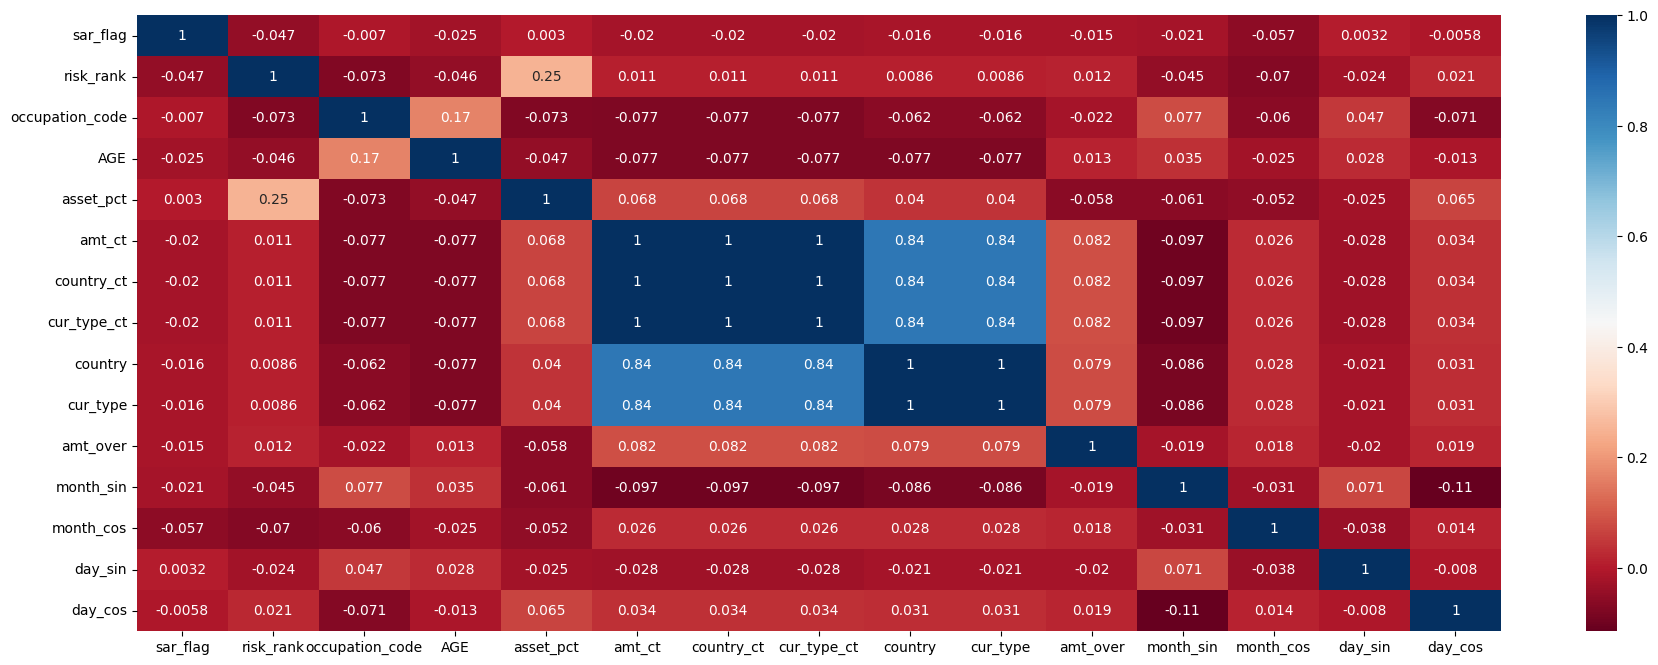

In [14]:
plt.figure(figsize=(22, 8))
corr = train.iloc[:, 1:].corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

In [15]:
train.columns

Index(['alert_key', 'sar_flag', 'risk_rank', 'occupation_code', 'AGE',
       'asset_pct', 'amt_ct', 'country_ct', 'cur_type_ct', 'country',
       'cur_type', 'amt_over', 'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [16]:
cat_col = ['risk_rank', 'occupation_code', 'AGE', 'country', 'cur_type', 'amt_over']
train[cat_col] = train[cat_col].astype(int)

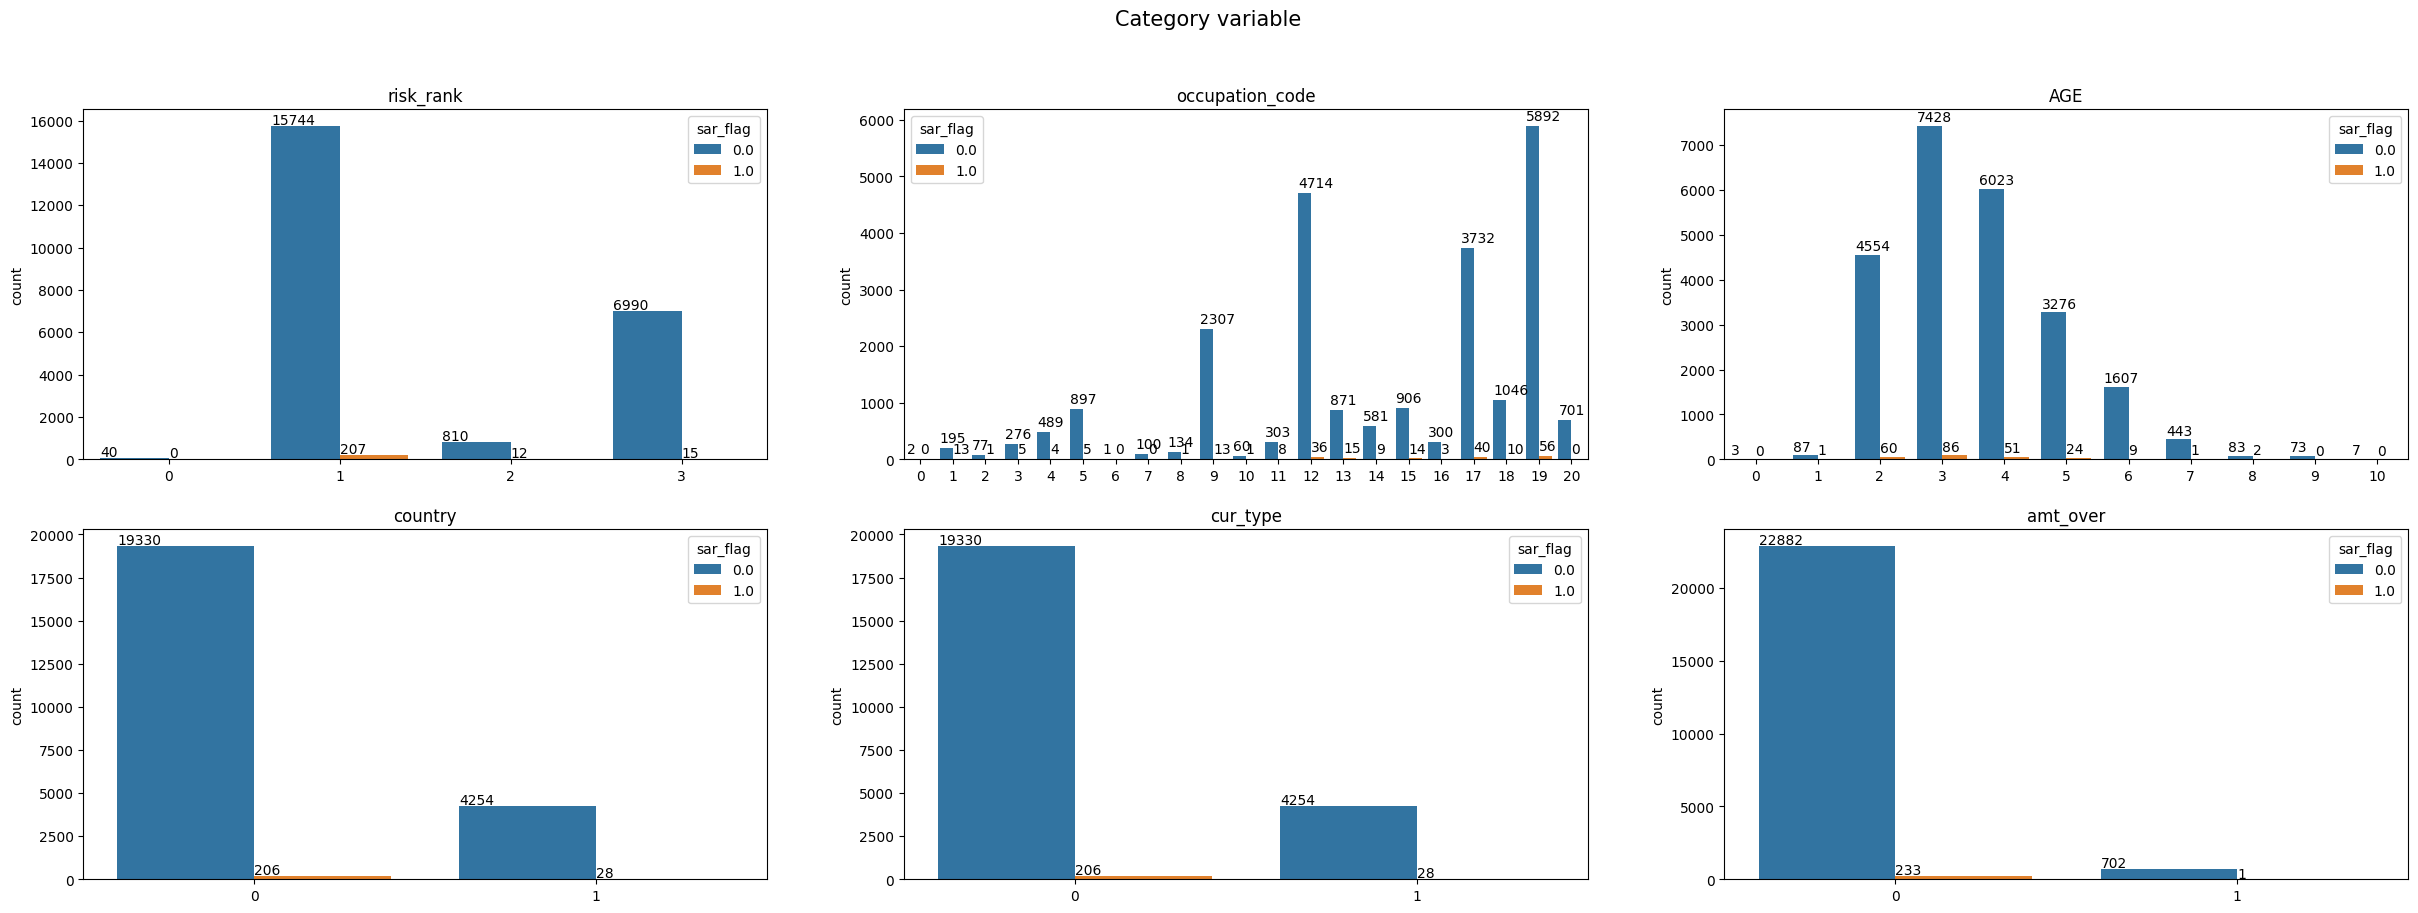

In [18]:
a, b = 2, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.countplot(x = cat_col[k], hue = "sar_flag", data = train, ax = ax[i, j])
        ax[i, j].set(xlabel = None, title = cat_col[k])


        for p in ax[i, j].patches:
            if np.isnan(p.get_height()):
                continue
            ax[i, j].annotate(f'\n{int(p.get_height())}', (p.get_x(), p.get_height()+100), size=10)

        k += 1
        if k >= len(cat_col):
            break
plt.suptitle("Category variable", size = 15)
plt.show()

# Split train、valid data

In [11]:
drop_feat = ["alert_key", "sar_flag"]

In [12]:
X_train = train.drop(drop_feat, axis = 1)
y_train = train["sar_flag"]

X_test = test.drop(drop_feat, axis = 1)

In [13]:
print(f"raw 1/0: {(y_train.value_counts()[1] / y_train.value_counts()[0]):.4}")
y_train.value_counts()

raw 1/0: 0.009922


0.0    23584
1.0      234
Name: sar_flag, dtype: int64

In [14]:
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state = 99)
# X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.3, shuffle = False)
print(X_train1.shape, X_valid.shape, y_train1.shape, y_valid.shape)

(19054, 14) (4764, 14) (19054,) (4764,)


In [15]:
print(f"train 1/0: {(y_train1.value_counts()[1] / y_train1.value_counts()[0]):.4}")
y_train1.value_counts()

train 1/0: 0.009911


0.0    18867
1.0      187
Name: sar_flag, dtype: int64

In [16]:
print(f"valid 1/0: {(y_valid.value_counts()[1] / y_valid.value_counts()[0]):.4}")
y_valid.value_counts()

valid 1/0: 0.009964


0.0    4717
1.0      47
Name: sar_flag, dtype: int64

## Resample

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN
oversample = SMOTE(random_state=99)
X_train1, y_train1 = oversample.fit_resample(X_train1, y_train1)
y_train1.value_counts()

0.0    18867
1.0    18867
Name: sar_flag, dtype: int64

In [18]:
oversample = SMOTE(random_state=99)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

0.0    23584
1.0    23584
Name: sar_flag, dtype: int64

## Target encoding

In [19]:
X_train1.head(3)

,risk_rank,occupation_code,AGE,asset_pct,amt_ct,country_ct,cur_type_ct,country,cur_type,amt_over,month_sin,month_cos,day_sin,day_cos
0,3,18,3,4.101152,425.0,425.0,425.0,1,1,0,0.5,-0.866025,-0.897805,-0.440394
1,1,13,2,4.236952,0.0,0.0,0.0,0,0,0,-0.5,-0.866025,0.394356,0.918958
2,2,17,5,1.247804,1.0,1.0,1.0,0,0,0,0.5,0.866025,0.571268,0.820763


In [20]:
import category_encoders as ce

cat_feat = ["occupation_code", "AGE"]#"risk_rank", 
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train1 = ce_target.fit_transform(X_train1, y_train1)
X_valid = ce_target.transform(X_valid)

In [21]:
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)

## Modeling

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


random_state = 99#None
models = {
    "Logistic": LogisticRegression(),
    "Bayes (Gaussian)": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    # "SVC": SVC(probability = True),
    # "Neural Network": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    "Random Forest": RandomForestClassifier(random_state = random_state),#, class_weight="balanced"),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(random_state = random_state),
    "LightGBM": LGBMClassifier(random_state = random_state), # feature name should be number
    # "Cat Boost": CatBoostClassifier(random_state = random_state),
    # "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train1, y_train1)
    print(name + " trained.")

Logistic trained.
Bayes (Gaussian) trained.
KNN trained.
Decision Tree trained.
Random Forest trained.
Gradient Boost trained.
XGBoost trained.
LightGBM trained.
Easy Ensemble (AdaBoost) trained.
Easy Ensemble (Logistic) trained.


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

# acc_bound = 0.7
# f1w_bound = 0.5

score = []
flag = 1
cv_flag = 0
for key, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_valid)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_valid, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train).round(2)
    recall_test   = recall_score(y_valid, pred_test).round(2)

    precision_train  = precision_score(y_train, pred_train).round(2)
    precision_test   = precision_score(y_valid, pred_test).round(2)

    f1_train = f1_score(y_train, pred_train).round(2)
    f1_test = f1_score(y_valid, pred_test).round(2)
    
    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["f1_cv"]

    score.append(col1)
    
    # if (acc_test >= acc_bound) & (f1_test >= f1w_bound):
    col3 = sorted(list(set(y_valid) | set(pred_test)))
    confusion = pd.DataFrame(confusion_matrix(y_valid, pred_test), index = col3, columns = col3)
    confusion["Total"] = confusion.sum(axis = 1)
    confusion.at["Total"] = confusion.sum(axis = 0)

    
    confusion = confusion.astype(int)
    
    print(f"<< {key.lstrip()} >>")
    print(f"\nConfusion Matrix:\n {confusion}")
    print(f"\nClassification Report:\n{classification_report(y_valid, pred_test)}")
    print("-"*60)
    
index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score = score.sort_values(["Recall_test", "Precision_test", "f1_test", "Accuracy_test"], ascending = False)
score

<< Logistic >>

Confusion Matrix:
         0.0   1.0  Total
0.0    3586  1131   4717
1.0      19    28     47
Total  3605  1159   4764

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      4717
         1.0       0.02      0.60      0.05        47

    accuracy                           0.76      4764
   macro avg       0.51      0.68      0.45      4764
weighted avg       0.99      0.76      0.85      4764

------------------------------------------------------------
<< Bayes (Gaussian) >>

Confusion Matrix:
         0.0   1.0  Total
0.0    2015  2702   4717
1.0       8    39     47
Total  2023  2741   4764

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.60      4717
         1.0       0.01      0.83      0.03        47

    accuracy                           0.43      4764
   macro avg       0.51      0.63      0.31      4764
weighted avg  

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,f1_train,f1_test
Bayes (Gaussian),0.68,0.43,0.94,0.83,0.62,0.01,0.75,0.03
Logistic,0.77,0.76,0.79,0.60,0.76,0.02,0.78,0.05
Easy Ensemble (Logistic),0.77,0.76,0.79,0.60,0.76,0.02,0.78,0.05
Easy Ensemble (AdaBoost),0.94,0.94,0.94,0.28,0.94,0.05,0.94,0.08
KNN,0.92,0.92,0.89,0.21,0.94,0.03,0.92,0.05
Gradient Boost,0.96,0.96,0.96,0.15,0.97,0.05,0.96,0.07
LightGBM,0.99,0.99,0.98,0.06,1.00,0.23,0.99,0.10
Decision Tree,0.96,0.98,0.92,0.06,0.99,0.05,0.96,0.05
XGBoost,0.99,0.99,0.98,0.02,1.00,0.17,0.99,0.04
Random Forest,0.97,0.99,0.94,0.02,1.00,0.08,0.97,0.03


In [24]:
best_model = score.index[0]
best_model

'Bayes (Gaussian)'

## Recall@N - 1 的 Precision

In [25]:
pred_valid  = models[best_model].predict_proba(X_valid)
pred_valid = pred_valid[:, 1]

valid = train.loc[y_valid.index]
valid = valid[["alert_key", "sar_flag"]]
valid["probability"] = pred_valid
valid = valid.sort_values("probability", ascending = False)
sar = np.where(valid["sar_flag"])[0]
recall = len(sar)/sar[-2]
print(f"total: {len(valid)},  SAR: {len(sar)}\n{len(sar)} / {sar[-1]} = {recall:.6}")

total: 4764,  SAR: 47
47 / 4619 = 0.0105571


## Submit

#### No valid: only use X_train to train

In [26]:
test_model = models[best_model]
# test_model.fit(X_train1, y_train1)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1191


array([9.81448062e-01, 9.99795761e-01, 9.81462452e-01, ...,
       1.97964098e-05, 9.99635348e-01, 1.93891218e-05])

#### Total train: use X_train and X_valid to train

In [27]:
test_model = models[best_model]
test_model.fit(X_train, y_train)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1269


array([9.86608944e-01, 9.99771650e-01, 9.86622233e-01, ...,
       7.78319953e-05, 9.99607394e-01, 7.18339923e-05])

In [28]:
result = test[["alert_key"]].copy()
result["probability"] = pred_prob
result

,alert_key,probability
23818,352249,0.986609
23819,352253,0.999772
23820,352254,0.986622
23821,352280,0.000036
23822,352282,0.997908
...,...,...
25658,365001,0.999562
25659,365004,0.000077
25660,365008,0.000078
25661,365009,0.999607


In [29]:
X_train.columns

Index(['risk_rank', 'occupation_code', 'AGE', 'asset_pct', 'amt_ct',
       'country_ct', 'cur_type_ct', 'country', 'cur_type', 'amt_over',
       'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [30]:
submit = pd.read_csv("D:\\Julie\\develop\\money_laundry\\data\\預測的案件名單及提交檔案範例.csv")
submit = submit[["alert_key"]]
submit = pd.merge(submit, result, on = "alert_key", how = "left")
submit["probability"] = submit["probability"].astype(float)
submit = submit.fillna(1e-5)
submit = submit.sort_values("probability", ascending = False)
submit

,alert_key,probability
1623,354818,0.999960
432,358464,0.999957
3432,357883,0.999954
712,361296,0.999942
2649,354971,0.999940
...,...,...
1130,356424,0.000000
2115,356054,0.000000
2751,352859,0.000000
1111,355815,0.000000


In [32]:
submit.to_csv("data/submit/1114.csv", index = False)